**jiNx**


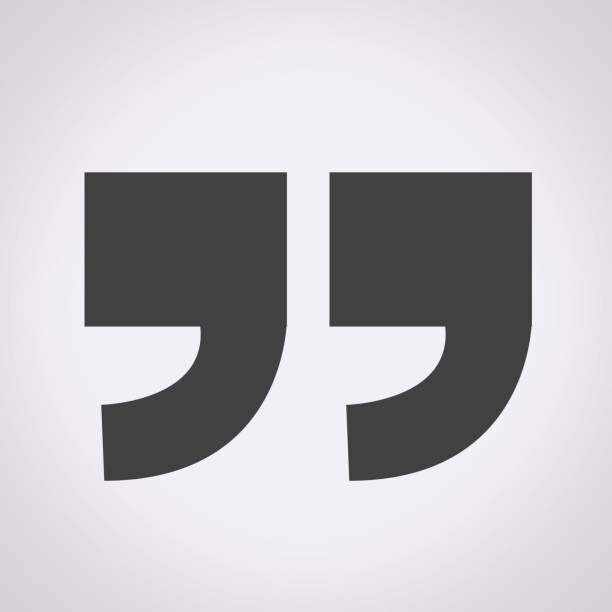

*It's not just Software, it's Connection*


Anthem Rukiya J. Wingate

CSE 805 Fall 2021

The North Carolina Agricultural and Technical State University


# Abstract

jiNx isn’t just software, it’s connection.  It is a solution predicated on the premise that each individual customer has a unique door to access our world, and we open it for them.  The door and everything on the other side is utterly unknown.  At jiNx we embrace that because the unknown is the one place engineers are themselves uniquely designed to inhabit.


*Why Build jiNx?*

Better to ask, how do we reach each other?  How do we connect when we are pulled ever farther apart by distance and ideology?  If information is the world’s only truly priceless commodity, connection is its most sought after resource.  Information may be parsed by qualifiers, like truth and relevance, that will ultimately determine who listens.  However, before those qualifiers can be applied, a connection must be leveraged to ensure information is disseminated to the widest possible audience.  In the prevailing zeitgeist of global economics, not just businesses, but ideas flourish or flounder given only one parameter - connection. 

What if a tool existed that could predict and guide users on how to amplify their  connection to the world around them?  A consumer seeking to expand their audience and ensure that they can effectively spread their core message is ultimately focused on optimizing connection.  jiNx is a platform of interwoven machine learning technologies with one goal in mind - a superlative connection.
Social media prediction is currently based on leveraging metadata.  The accuracy of those predictions relies on the assumption that the content itself is an unnecessary source of influence on prediction.  jiNx posits that predicting the response to social media content on the basis of the context of the content can be at least as reliable if not more accurate.  In the context of the global posture by which we socialize, we are connected most effectively, efficiently, and broadly through social media.  No matter what the message, ensuring that it reaches an ever-widening audience is the key concern of those who utilize social media.  Businesses, political and social justice movements, even emergency response coordination relies on social media for the purpose of distribution of key messaging.  Predicting whether the message will successfully reach its target audience or determining how to shape a message so that it reaches the broadest possible audience is why jiNx is a timely and useful product.  

jiNx 1.0 obtains the transcript of a video from a provided Youtube URL.  The transcript is obtained utilizing the IBM Speech to Text service.  The transcript is in turn sent to the IBM Tone Analyzer service.  The Tone Analyzer service outputs ratings of the emotional tone of the transcript based on these eight emotions: Anger, Disgust, Fear, Joy, Sadness, Confident, Analytical, Tentative.  The tone analysis ratings and view count are stored as a record in a PostGreSQL database through the IBM Databases as PostGreSQL service.
Once sufficient data has been collected on the PGSQL instance, the database is exported  to a local CSV file.  The CSV file is utilized as training data for a Multivariate Regression Machine Learning model.  Once the model has been sufficiently trained, the model is utilized to predict view count of a test video.  The test video is analyzed using IBM Watson Natural Language Understanding to provide corrective insight as necessary to the end user. 

# Prepare the Environment

In [1]:
# Prep environment:  setup commandline method and import necessary libraries 

from __future__ import absolute_import, division, print_function, unicode_literals
# from watson_machine_learning_client import WatsonMachineLearningAPIClient
from google.colab import files
from google.colab import drive
import tarfile
import os 
from pathlib import Path
import json
import requests
import sys
import shutil
import re
from tqdm import tqdm, trange
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.client import device_lib
import time
from datetime import datetime
import csv
import argparse
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from numpy import mean, std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Run and print a shell command.
def run(cmd):
  print('>> {}'.format(cmd))
  !{cmd}  # This command runs the user input as a command in the shell.  This code cell can be reused for other necessary activities in the shell.

# add tensor flow 
%tensorflow_version 2.x 

drive.mount('/content/drive')
run('mkdir -p src/')
run('ls -lh src/')

Mounted at /content/drive
>> mkdir -p src/
>> ls -lh src/
total 0


In [2]:
# transfer training file to notebook directory
file_name = 'init.csv'  #@param {type: "string"}
file_dest = "src/" + file_name
shutil.copyfile(src="/content/drive/MyDrive/datasets/" + file_name, dst=file_dest)
run('ls -lh src/')

>> ls -lh src/
total 32K
-rw-r--r-- 1 root root 31K Nov 17 16:36 init.csv


# Descriptive Statistics

In [3]:
# Load dataset.
dftrain = pd.read_csv(file_dest)
dftrain = dftrain.drop('URL', axis=1)
print(F"Training data shape: {dftrain.shape}")

Training data shape: (226, 10)


In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          226 non-null    int64  
 1   ANGER       226 non-null    float64
 2   DISGUST     226 non-null    int64  
 3   FEAR        226 non-null    float64
 4   JOY         226 non-null    float64
 5   SADNESS     226 non-null    float64
 6   TENTATIVE   226 non-null    float64
 7   ANALYTICAL  226 non-null    float64
 8   CONFIDENT   226 non-null    float64
 9   VIEWS       226 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 17.8 KB


In [5]:
dftrain.describe()

,ID,ANGER,DISGUST,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT,VIEWS
count,226.000000,226.000000,226.0,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,2.260000e+02
mean,113.500000,0.459608,0.0,0.135158,0.379476,0.314625,0.672091,0.638810,0.635032,2.730170e+06
std,65.384759,0.257486,0.0,0.277992,0.334405,0.306333,0.226021,0.099838,0.296438,4.590516e+06
min,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.310000e+02
25%,57.250000,0.544876,0.0,0.000000,0.000000,0.000000,0.679647,0.575079,0.656784,1.810078e+05
50%,113.500000,0.577548,0.0,0.000000,0.585407,0.517019,0.719143,0.591673,0.757996,1.068544e+06
75%,169.750000,0.593131,0.0,0.000000,0.682706,0.588549,0.787256,0.713815,0.800187,3.053580e+06
max,226.000000,0.931034,0.0,0.931034,0.880435,0.916667,0.984352,0.997932,0.942582,4.155812e+07


In [6]:
dftrain.head(5)

,ID,ANGER,DISGUST,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT,VIEWS
0,1,0.576674,0,0.0,0.000000,0.000000,0.700148,0.587578,0.793762,4034155
1,2,0.000000,0,0.0,0.697598,0.604259,0.797051,0.749305,0.865994,368612
2,3,0.584267,0,0.0,0.000000,0.581470,0.727649,0.578724,0.808171,5498684
3,4,0.597095,0,0.0,0.553043,0.813960,0.599641,0.570430,0.749891,138764
4,5,0.618312,0,0.0,0.000000,0.000000,0.789754,0.575111,0.751512,150865


In [7]:
# Create Classes
def create_classes():
  bins = []
  for val in dftrain['VIEWS']:
    if val<=1000:
      bins.append(0)
    elif ((1001 <= val) & (val < 10001)):
      bins.append(1)
    elif ((10001 <= val) & (val < 100001)):
      bins.append(2)
    elif ((100001 <= val) & (val < 1000000)):
      bins.append(3)
    else:
      bins.append(4)
  return bins

dftrain = dftrain.assign(Class=create_classes())


In [8]:
dftrain.head(5)

,ID,ANGER,DISGUST,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT,VIEWS,Class
0,1,0.576674,0,0.0,0.000000,0.000000,0.700148,0.587578,0.793762,4034155,4
1,2,0.000000,0,0.0,0.697598,0.604259,0.797051,0.749305,0.865994,368612,3
2,3,0.584267,0,0.0,0.000000,0.581470,0.727649,0.578724,0.808171,5498684,4
3,4,0.597095,0,0.0,0.553043,0.813960,0.599641,0.570430,0.749891,138764,3
4,5,0.618312,0,0.0,0.000000,0.000000,0.789754,0.575111,0.751512,150865,3


In [9]:
# Get class distribution
print(dftrain.groupby('Class').size())

Class
0      4
1      8
2     19
3     79
4    116
dtype: int64


<function matplotlib.pyplot.show>

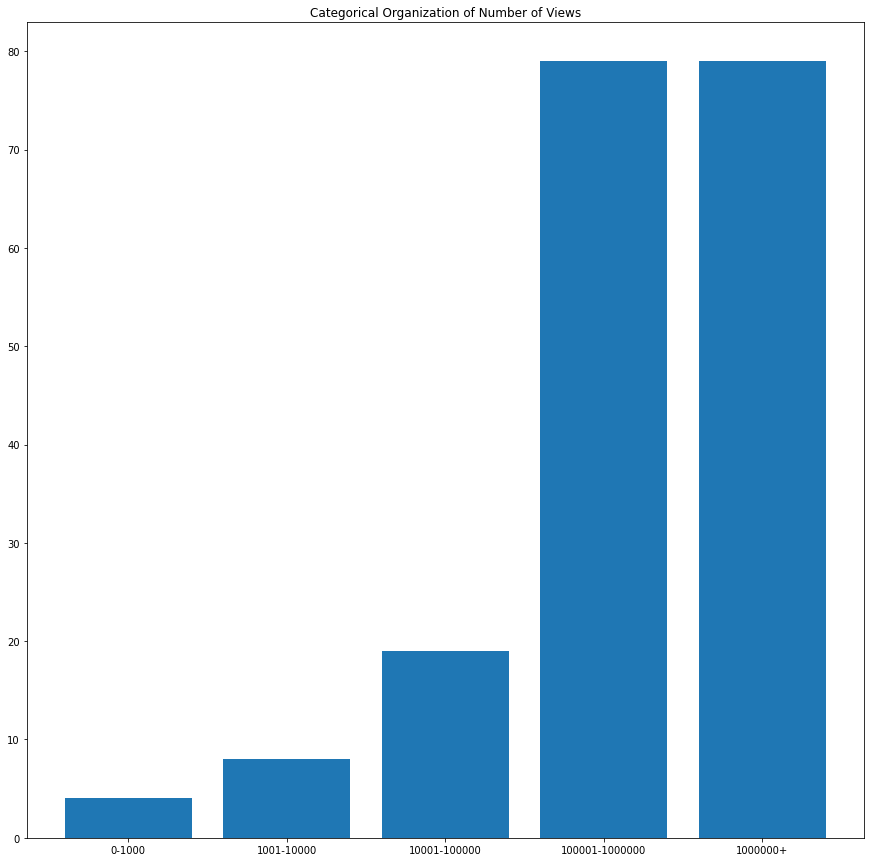

In [10]:
# Get Bar Plots 
y = dftrain['VIEWS']
brpltx = ['0-1000','1001-10000', '10001-100000', '100001-1000000', '1000000+']
y1 = y.where(y <= 1000).count()
y2 = y.where((1001 <= y) & (y < 10001)).count()
y3 = y.where((10001 <= y) & (y < 100001)).count()
y4 = y.where((100001 <= y) & (y < 1000000)).count()
y5 = y.where(y >= 1000000).count()
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(15)
plt.title(label='Categorical Organization of Number of Views')
brplty = [y1, y2, y3, y4, y4]
plt.bar(brpltx, brplty)
plt.show

# Data Preprocessing

In [11]:
df_corr = dftrain.drop(['ID', 'VIEWS', 'DISGUST','Class'], axis=1)
print("The correlation coefficients are as follows:")
df_corr.corr(method='pearson')

The correlation coefficients are as follows:


,ANGER,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT
ANGER,1.000000,-0.207496,-0.373430,-0.288332,-0.194493,-0.475151,-0.035138
FEAR,-0.207496,1.000000,0.224418,0.345497,0.148608,0.341892,0.112505
JOY,-0.373430,0.224418,1.000000,0.325447,0.056383,0.479548,0.171430
SADNESS,-0.288332,0.345497,0.325447,1.000000,0.259584,0.382046,0.101078
TENTATIVE,-0.194493,0.148608,0.056383,0.259584,1.000000,0.351914,0.173252
ANALYTICAL,-0.475151,0.341892,0.479548,0.382046,0.351914,1.000000,0.272782
CONFIDENT,-0.035138,0.112505,0.171430,0.101078,0.173252,0.272782,1.000000


In [12]:
# Get Boxplots
def get_box_plots(name, dataset):
  # Get box and whisker plots
  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title(F"jiNx Visualization - {name} Boxplot")
  ax.autoscale()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)

  # Remove y-axis tick marks
  ax.yaxis.set_ticks_position('none')

  # Add major gridlines in the y-axis
  ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

  # Set column names as labels for the boxplot
  ax.boxplot(dataset, labels=[name], whis=[0.3,99.7])

  plt.show()

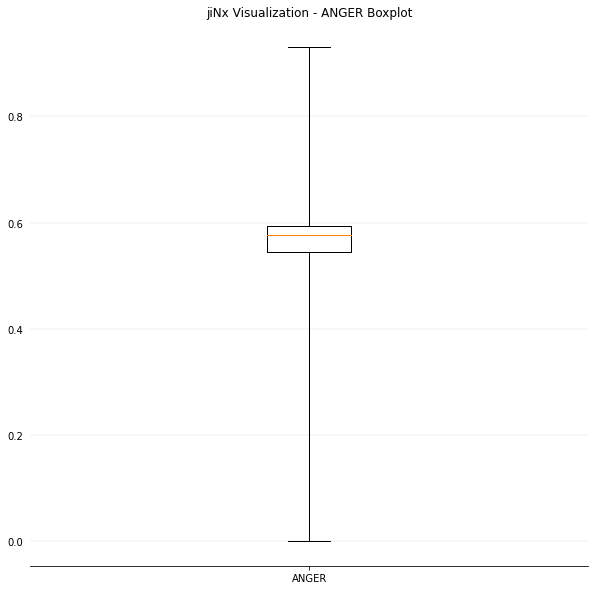

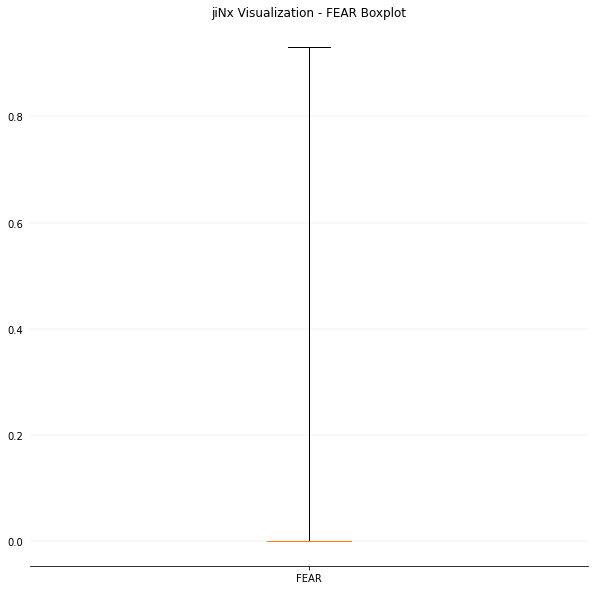

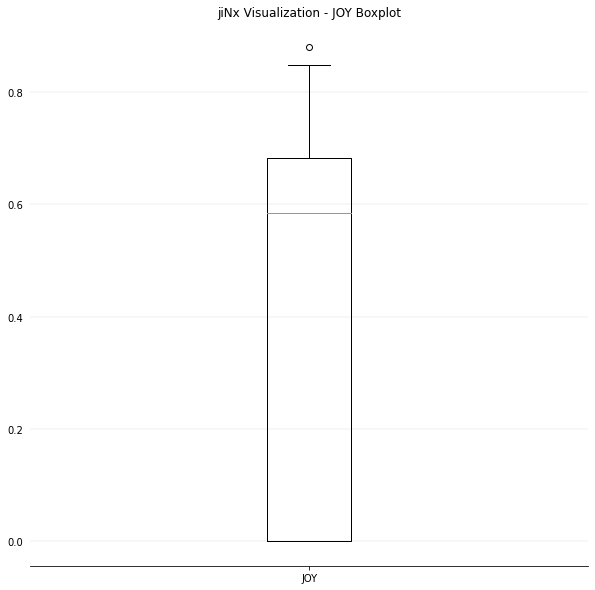

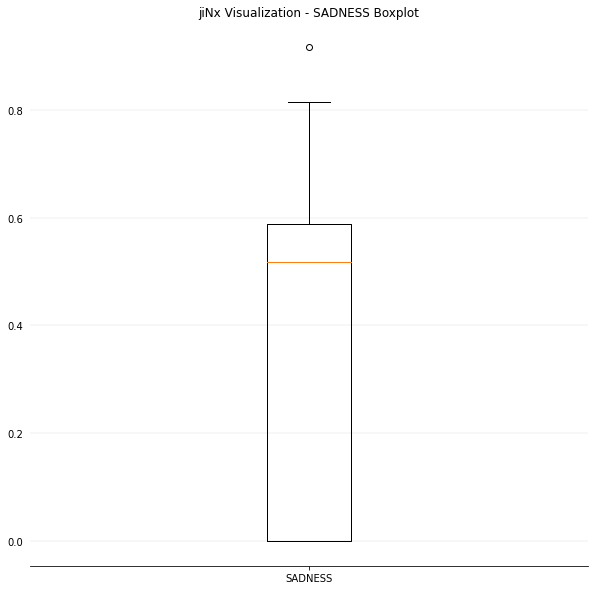

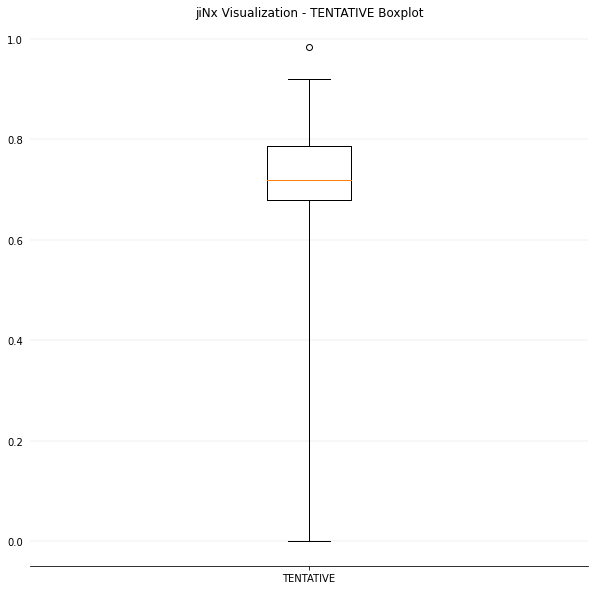

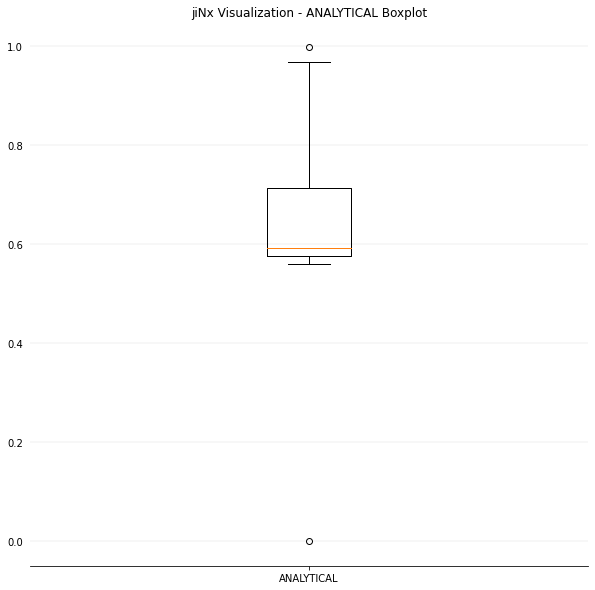

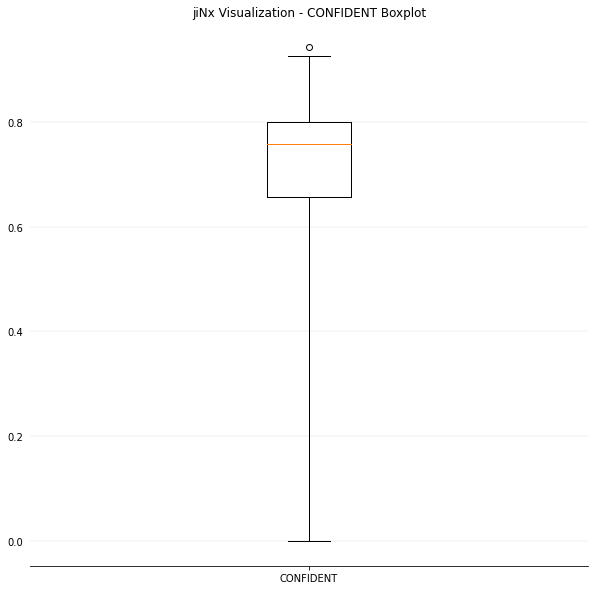

In [13]:
df = dftrain.drop(['ID', 'VIEWS', 'DISGUST','Class'], axis=1) # Prep data

# Get box and whisker plots
for col in df.columns:
  get_box_plots(col, df[col])

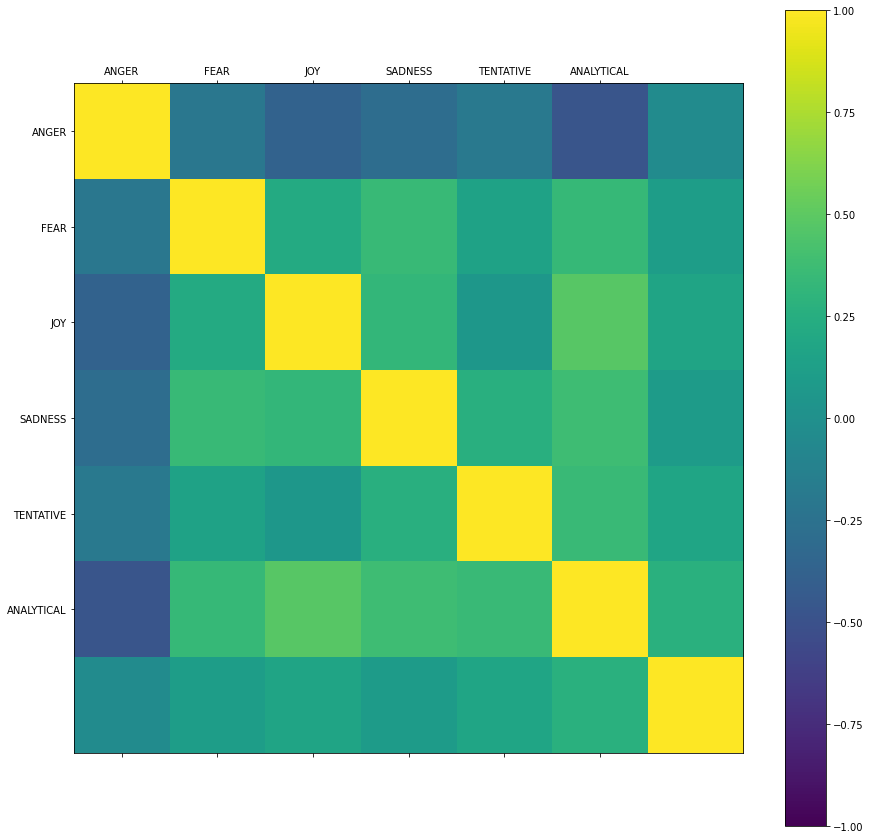

In [14]:
# Get Correction Matrix Plot
correlations = df.corr()
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(15)
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

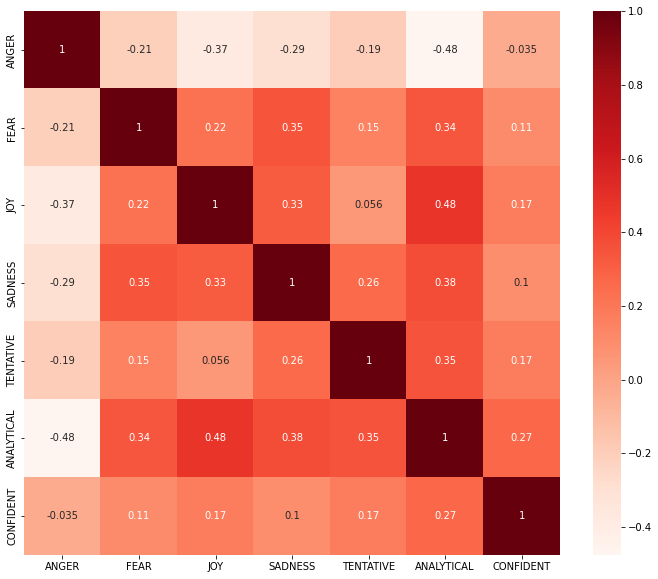

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [16]:
def get_summary_statistics(dataset):
    
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.median(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    quartile_1 = np.round(dataset.quantile(0.25), 2)
    quartile_3 = np.round(dataset.quantile(0.75), 2)
    # Interquartile range
    iqr = np.round(quartile_3 - quartile_1, 2)
    print('Min: %s' % min_value)
    print('Mean: %s' % mean)
    print('Max: %s' % max_value)
    print('25th percentile: %s' % quartile_1)
    print('Median: %s' % median)
    print('75th percentile: %s' % quartile_3)
    print('Interquartile range (IQR): %s' % iqr)

In [17]:
# Get Summary Statistics
for column in df.columns:
  print(F"\n\n{column} summary statistics")
  get_summary_statistics(df[column])



ANGER summary statistics
Min: 0.0
Mean: 0.46
Max: 0.93
25th percentile: 0.54
Median: 0.58
75th percentile: 0.59
Interquartile range (IQR): 0.05


FEAR summary statistics
Min: 0.0
Mean: 0.14
Max: 0.93
25th percentile: 0.0
Median: 0.0
75th percentile: 0.0
Interquartile range (IQR): 0.0


JOY summary statistics
Min: 0.0
Mean: 0.38
Max: 0.88
25th percentile: 0.0
Median: 0.59
75th percentile: 0.68
Interquartile range (IQR): 0.68


SADNESS summary statistics
Min: 0.0
Mean: 0.31
Max: 0.92
25th percentile: 0.0
Median: 0.52
75th percentile: 0.59
Interquartile range (IQR): 0.59


TENTATIVE summary statistics
Min: 0.0
Mean: 0.67
Max: 0.98
25th percentile: 0.68
Median: 0.72
75th percentile: 0.79
Interquartile range (IQR): 0.11


ANALYTICAL summary statistics
Min: 0.0
Mean: 0.64
Max: 1.0
25th percentile: 0.58
Median: 0.59
75th percentile: 0.71
Interquartile range (IQR): 0.13


CONFIDENT summary statistics
Min: 0.0
Mean: 0.64
Max: 0.94
25th percentile: 0.66
Median: 0.76
75th percentile: 0.8
Interq

# Preprocessing Analysis

**Preliminary data analysis of jiNx machine learning model-based prediction tool**

The complexity of the problem presented by jiNx is not determined to reside in its core definition so much as the underlying considerations.  It is certainly possible to identify and predict behavior of a specific demographic.  This is accomplished quite successfully when contemplating the efforts expended by corporations in pursuit of consumers.  A clear observation of this is within politics. Marketing analysts are able to quantify human behavior down to how voters will respond to a hair cut, a chosen catch phrase or the color of a suit jacket worn by a candidate. Thus, the complexity of the question of predicting the popularity of a YouTube video based on the tone analysis of the transcript of said video, is not held in determining whether these are adequate parameters.  In fact, the complexity is in cataloguing  and modeling human response to specific stimuli.  The collected sample of data is likely sufficient to make fairly accurate predictions.  However, a dimension of the analysis is missing.  Without having a parallel model to determine typical human response to each individual emotional tone, the data loses a great deal of impact as a means to predict a video’s potential for attracting views.


With this in mind, it is possible to assess the relevance of this single dimension of the data in regards to the proposed question.  Meaning, any level of accuracy at or above fifty percent is highly favorable, assuming that the other dimension is equally weighted.  Given this understanding, there are a few initial assumptions that can be declared based on the illuminating results of the pre-processing step.


Though there is a preponderance of zeroes in the DISGUST and FEAR parameters, these are not null values.  The expectation could be, when considered in reference to viewer reaction, that limited expressions of disgust and fear in the transcript will increase viewership.  Thus the values must be retained as they are relevant data points.


In addition, correlations roughly between 0.5 and 0.8 can be observed for the SADNESS and ANALYTICAL emotional tones.  The expectation could be, when considered in reference to viewer reaction, that viewers tend to identify greatly with videos that convey both sadness and rationale.  Instructional videos and emotional testimonies both tend to be highly sought after by viewers.  


Based on the limited number of highly impactful parameters, a standardization followed by a PCA analysis limited to two parameters will likely assist significantly in finding an adequate fit for the data.  In addition, Though initial intentions are to make predictions using linear regression, a polynomial regression model may yield better results.  Based on the outcome of the preprocessing, it will be imperative to utilize classification as a means of determining a range of values for accurate predictions prior to applying the trained regression model to new samples of data.


# Feature Engineering

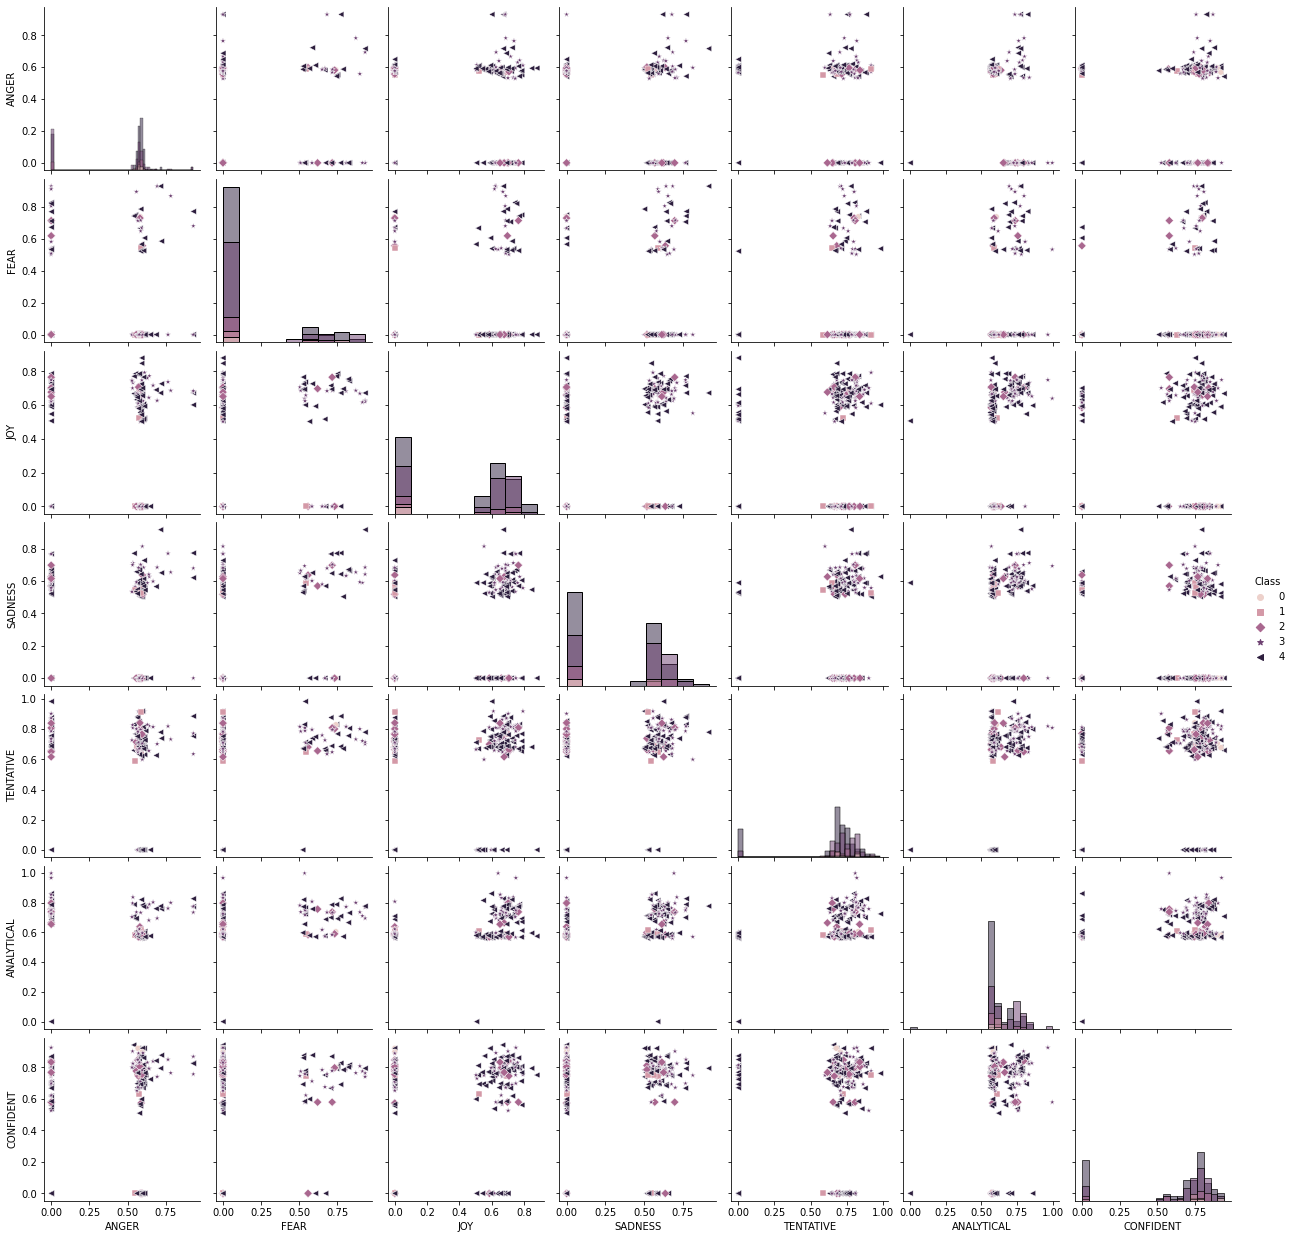

In [18]:
df_pair = df.assign(Class=dftrain['Class'])
# Get Pairwise Scatterplot
sns.pairplot(df_pair, hue="Class", diag_kind="hist", markers=["o", "s", "D", "*", "<"])

In [19]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
top_corr = get_top_abs_correlations(df_corr, 3)
print(top_corr)

Top Absolute Correlations
JOY      ANALYTICAL    0.479548
ANGER    ANALYTICAL    0.475151
SADNESS  ANALYTICAL    0.382046
dtype: float64


# Feature Engineering Analysis

**How is Parasocial Interaction Relevant to jiNx**

*What is it?*

> “A parasocial relationship, first defined by Horton and Wohl, consists of one-sided and one-way mediated symbolic interactions between a viewer and a media persona (presenter, actor, singer, or other celebrity), whereby the media persona is perceived to be a “friend” by the viewer.  A parasocial relationship is, thus, built from sequential parasocial one-way interactions from the viewer to the media persona.  Many scholars have applied these theoretical constructs of parasocial interactions and relationships to their study of the audience-media relationship.” (Horton &Wohl, 1956)

	
*Why is this connected?*

“Viewers interactions with media characters foster positive reactions towards the media product that have been reported, in turn, to be strongly linked to viewing motives, attitudes, and activity levels.  Hence, stimulating viewers’ symbolic interactions with a TV programme and their parasocial relationships with the programme characters may lead to high levels of involvement that may be connected to media producers successfully promoting their product.” (Dibble et al., 2016; Liebers & Schramm, 2019)


*Key Types of Parasocial Interaction that are of relevance to jiNx*

> Referential Involvement - symbolic connection between the media character’s experience and the viewer’s personally lived experience (Liebes & Katz, 1986)

> Critical Involvement - viewer’s aesthetic engagement with the media product as a whole (Liebes & Katz, 1986)


*Utilizing Korean Television Study Data (Kim & Sintas, 2021)*

> Establishing the presence of parasocial interaction - The study first scraped social media sources to find evidence of parasocial interactions with television shows that fall within one of three classes of popularity, i.e. low, moderate, or high.  

> Establishing the defined involvement outcome of established parasocial interaction - Topic clouds were created based on the scraped social media sources which reflect the specific type of parasocial outcome.  The distribution of parasocial outcomes based on the proportion of data that specifically reflects each topic clouds of relevance as pertains to jiNx are as follows:

> * Topic 2: Empathy 31%
> * Topic 3: Criticism 19%
> * Topic 10: Behavior 17%
> * Topic 12: Expression of emotion 10%
> * Topic 8: Referential Involvement 4%
> * Topic 6: Cognitive 4%

> Establishing a correlation between the defined involvement outcome and level of popularity of the television show, i.e. less, moderately, or more popular - A linear model was created correlating popularity of an episode of television with the prevalence of data scraped from social media referencing that episode.  The regression model for the six key parasocial interaction outcomes of relevance for jiNx all show positive correlation with popularity with the exception of the topics of behavior and empathy.

*Conclusions*

> Popularity of a media product is critically influenced by the Cognitive, Referential, Criticism, and Expression of Emotion topics directly reflecting parasocial interaction outcomes of the audience.

*Implementation*

> Topic Modelling percentages can be utilized as the equivalent for the explained variance of Principal Component Analysis.  Converting topic percentages to PCA yields an accounting of 82% of the variance.

> * Criticism: 19/36 = 0.5378 => Attribute 54% of variance to Analytical, Confident, Tentative

> * Expression of Emotion: 10/36 = 0.2778 => Attribute 28% of variance to Joy, Sadness, Anger, Fear

> * Cognitive: 4/36 = 0.1111 => will remain unattributed

> * Referential Involvement: 4/36  = 0.1111 => will remain unattributed


# Modeling

**Classification**

In [20]:
# Transform Data using Z-Score Standardization and PCA

df_transform =  dftrain.drop(['ID', 'DISGUST','Class'], axis=1)
columns = df_transform.columns
df_standardized = StandardScaler().fit_transform(df_transform) # normalizing the features

"""
df_standardized = []

for column in columns:
  feature = np.array(df_transform[column])
  df_standardized.append(stats.zscore(feature))

df_standardized = np.array(df_standardized)
df_standardized = np.transpose(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=columns)
df_standardized_y = df_standardized['VIEWS']
df_standardized = df_standardized.drop('VIEWS', axis=1)
"""

pca = PCA(n_components=4) # reduced to four principal components based on highest correlation coefficients
pca_fit_transform = pca.fit_transform(df_standardized)
pca_fit = pca.fit(df_standardized)
df_pca = pd.DataFrame(pca_fit_transform, columns=['PC1','PC2','PC3','PC4'])
df_pca_disp = df_pca
df_pca_disp['Class'] = dftrain['Class']
pca_comps = pca_fit.components_
exp_var_pca = pca_fit.explained_variance_ratio_

# summarize components
print(F"Explained Variance\n {exp_var_pca}\n\n")
print(F"PCA Components\n {pca_comps}\n\n")
print("PCA Fit Training Data")
print(df_pca_disp.head(20))



Explained Variance
 [0.32993115 0.14740921 0.11747919 0.11018879]


PCA Components
 [[-0.39516389  0.3397766   0.39713613  0.40135344  0.30132884  0.50582859
   0.22150684 -0.11776573]
 [-0.21213783  0.12162536  0.33400427  0.13364595 -0.48856766 -0.01174173
  -0.36134923  0.66436076]
 [ 0.24672292 -0.09754925  0.25523163 -0.19488834 -0.26444251  0.06970518
   0.82597985  0.26354491]
 [ 0.46326506  0.621333   -0.33518133  0.36813234  0.16648372 -0.15563297
   0.09598242  0.30051914]]


PCA Fit Training Data
         PC1       PC2       PC3       PC4  Class
0  -1.347729 -0.732881  0.519828  0.148415      4
1   2.262030 -0.143108  0.104709 -1.262621      3
2  -0.630956 -0.348620  0.242429  0.997330      4
3   0.193846 -0.131892  0.202701  0.292798      3
4  -1.287144 -1.471555  0.104598  0.040626      3
5  -1.820851 -0.281026 -1.893975 -0.394058      3
6  -1.376238 -1.206764 -0.402237 -0.097146      2
7   1.867579 -0.013575  0.050261  2.200306      3
8  -0.278123  1.438477  1.023837  0.6

**Observation of PCA results indicates further Feature Envineering steps**

In the initial PCA analysis, the 11 % variance observed for PCA 3 and PCA 4 coincides with the conclusions made by Kim and Sintas in their paper "Social TV viewers’ symbolic parasocial interactions with media characters: A topic modelling analysis of viewers’ comments".  As a result, the PCA components will be reduced from n=4 to n=2.

In [21]:
pca = PCA(n_components=2) # reduced to two principal components based on literature
pca_fit_transform = pca.fit_transform(df_standardized)
pca_fit = pca.fit(df_standardized)
df_pca = pd.DataFrame(pca_fit_transform, columns=['PC1','PC2'])
df_pca_disp = df_pca
df_pca_disp['Class'] = dftrain['Class']
pca_comps = pca_fit.components_
exp_var_pca = pca_fit.explained_variance_ratio_

# summarize components
print(F"Explained Variance\n {exp_var_pca}\n\n")
print(F"PCA Components\n {pca_comps}\n\n")
print("PCA Fit Training Data")
print(df_pca_disp.head(20))

Explained Variance
 [0.32993115 0.14740921]


PCA Components
 [[-0.39516389  0.3397766   0.39713613  0.40135344  0.30132884  0.50582859
   0.22150684 -0.11776573]
 [-0.21213783  0.12162536  0.33400427  0.13364595 -0.48856766 -0.01174173
  -0.36134923  0.66436076]]


PCA Fit Training Data
         PC1       PC2  Class
0  -1.347729 -0.732881      4
1   2.262030 -0.143108      3
2  -0.630956 -0.348620      4
3   0.193846 -0.131892      3
4  -1.287144 -1.471555      3
5  -1.820851 -0.281026      3
6  -1.376238 -1.206764      2
7   1.867579 -0.013575      3
8  -0.278123  1.438477      4
9  -1.286136 -1.288535      3
10  2.220024  0.119416      4
11 -1.204638 -1.476113      3
12 -3.559449  2.843018      4
13  2.368239 -0.219133      4
14  1.048383  0.960514      4
15 -1.236725 -1.137886      3
16 -1.437353 -0.922738      4
17 -0.398152 -1.230729      3
18 -2.970373  1.548011      4
19  2.373505  0.150892      3


In [22]:
print(F"Range of values of PC1 is {min(df_pca['PC1'].tolist())} to {max(df_pca['PC1'].tolist())}")
print(F"Range of values of PC2 is {min(df_pca['PC2'].tolist())} to {max(df_pca['PC2'].tolist())}")

Range of values of PC1 is -3.559449202881739 to 4.013943209120764
Range of values of PC2 is -1.6356890659682721 to 6.252811026573658


<Figure size 432x288 with 0 Axes>

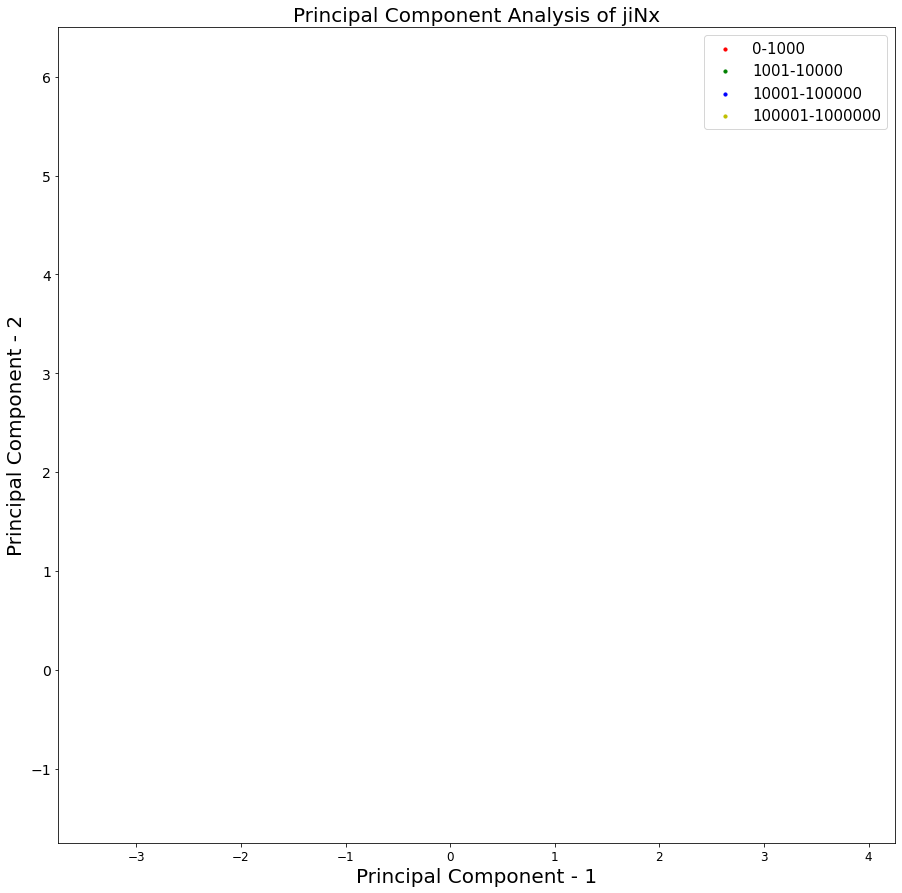

In [23]:
plt.figure()
plt.figure(figsize=(15,15))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of jiNx",fontsize=20)

targets = brpltx
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
  indicesToKeep = df_pca['Class'] == target
  plt.scatter(df_pca.loc[indicesToKeep, 'PC1'], df_pca.loc[indicesToKeep, 'PC2'], c = color, s = 10)
  
plt.legend(targets,prop={'size': 15})
plt.xlim([-3.75, 4.25])
plt.ylim([-1.75, 6.5])
plt.show()

In [24]:
# Function for displaying summary statistics during cross validation step

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [25]:
# Split Data frame for training and validation
x_train, x_validation, y_train, y_validation = train_test_split(df_pca.values, dftrain['Class'], test_size=0.20, random_state=42)
print(F"X Values Training Data Shape: {x_train.shape}")
print(F"X Values Validation Data Shape: {x_validation.shape}")
print(F"Y Values Training Data Shape: {y_train.shape}")
print(F"Y Values Validation Data Shape: {y_validation.shape}")

X Values Training Data Shape: (180, 3)
X Values Validation Data Shape: (46, 3)
Y Values Training Data Shape: (180,)
Y Values Validation Data Shape: (46,)


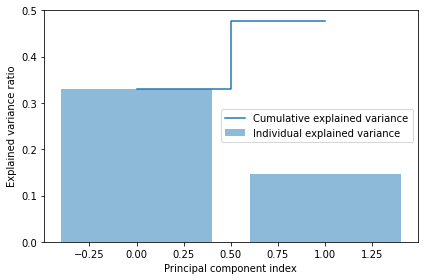

In [26]:
# Cumulative sum of eigenvalue
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.772222 (0.080316)
LDA: 0.661111 (0.100769)
KNN: 0.950000 (0.046148)
CART: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
SVM: 0.972222 (0.027778)


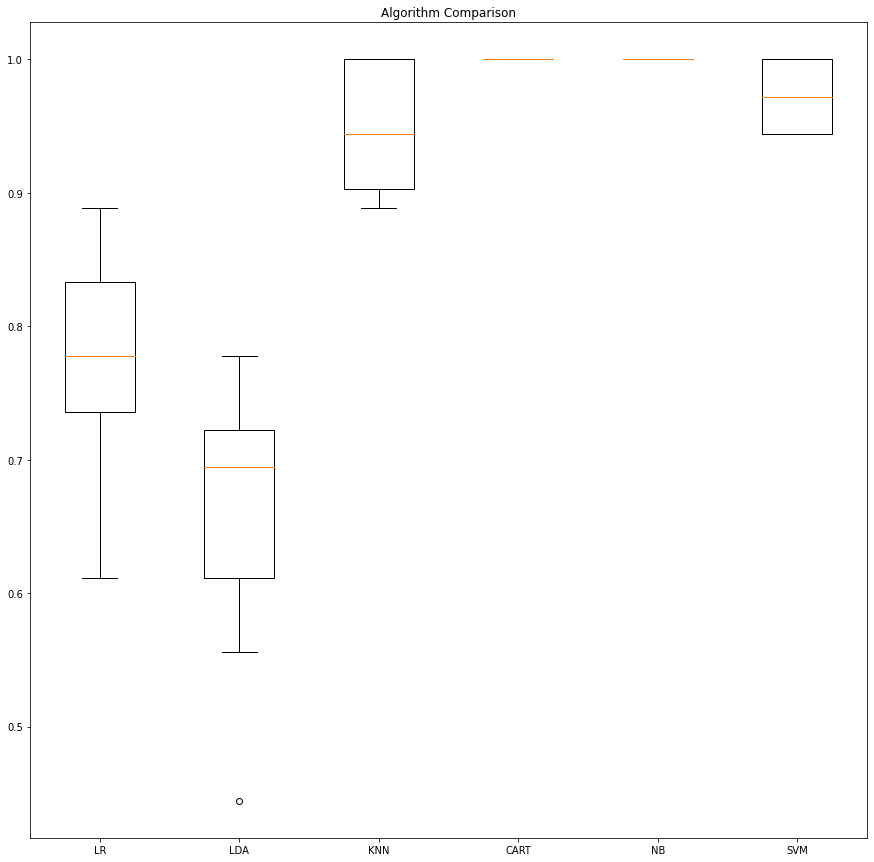

In [28]:
# Compare Algorithms
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(15)
plt.boxplot(results, labels=names, )
plt.title('Algorithm Comparison')
plt.show()

In [29]:
# Make predictions on validation dataset with best fit models

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
lr_predictions = lr_model.predict(x_validation)

# Linear Discriminant Analysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train, y_train)
lda_predicitons = lda_model.predict(x_validation)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_model.fit(x_train, y_train)
knn_predictions = knn_model.predict(x_validation)

# SVM
svm_model = SVC(kernel='poly', degree=6)
svm_model.fit(x_train, y_train)
svm_predictions = svm_model.predict(x_validation)

In [30]:
# Evaluate predictions

# Logistic predictions
print("Logistic Regression Predictions\n")
print("Accuracy: ", accuracy_score(y_validation, lr_predictions))
print("\n")
print("Confusion Matrix: \n", confusion_matrix(y_validation, lr_predictions))
print("\n")
print("Classification Report: \n", classification_report(y_validation, lr_predictions))
print("\n")

# Linear Discriminant Analysis
print("Linear Discriminant Predictions\n")
print("Accuracy: ", accuracy_score(y_validation, lda_predicitons))
print("\n")
print("Confusion Matrix: \n", confusion_matrix(y_validation, lda_predicitons))
print("\n")
print("Classification Report: \n", classification_report(y_validation, lda_predicitons))
print("\n")

# KNN predictions
print("k-Nearest Neighbors Predictions\n")
print("Accuracy: ", accuracy_score(y_validation, knn_predictions))
print("\n")
print("Confusion Matrix: \n", confusion_matrix(y_validation, knn_predictions))
print("\n")
print("Classification Report: \n", classification_report(y_validation, knn_predictions))
print("\n")

# SVM predictions
print("Support Vector Machines Predictions\n")
print("Accuracy: ", accuracy_score(y_validation, svm_predictions))
print("\n")
print("Confusion Matrix: \n", confusion_matrix(y_validation, svm_predictions))
print("\n")
print("Classification Report: \n", classification_report(y_validation, svm_predictions))

Logistic Regression Predictions

Accuracy:  0.8913043478260869


Confusion Matrix: 
 [[ 0  1  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  2  3  0]
 [ 0  0  0 13  0]
 [ 0  0  0  0 26]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.67      0.40      0.50         5
           3       0.81      1.00      0.90        13
           4       1.00      1.00      1.00        26

    accuracy                           0.89        46
   macro avg       0.50      0.48      0.48        46
weighted avg       0.87      0.89      0.87        46



Linear Discriminant Predictions

Accuracy:  0.6304347826086957


Confusion Matrix: 
 [[ 0  0  0  1  0]
 [ 0  0  0  1  0]
 [ 0  0  0  5  0]
 [ 0  0  0 10  3]
 [ 0  0  0  7 19]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     

**Observation of Algorithm Comparison Indicates Further Modeling Steps**

The results observerd in the box plots indicate that SVM and KNN are both very well-fit classification models.  

Assuming that the outcomes of the classification step are accurate, these models can be used to pre-predict the range of expected views prior to applying a regression model.  A Polynomial Regression will be implemented under the assumption that a second order polynomial could be derived from the model fit to the data described in the literature by Kim & Sintas.

**Regression**

In [31]:
# evaluate knn on the dataset with polynomial features transform

# separate into input and output columns
X = df_pca.drop(['Class'], axis=1)
y = dftrain['Class']
y = LabelEncoder().fit_transform(y.astype('str'))

# define the pipeline
trans = PolynomialFeatures(degree=3)
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])

# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



Accuracy: 0.599 (0.047)


In [45]:
# Evaluate Linear Regression on the dataset with polynomial features transform

# separate into input and output columns
X = df_pca.drop(['Class'], axis=1)
y = dftrain['Class']
y = LabelEncoder().fit_transform(y.astype('str'))

# define the pipeline
trans = PolynomialFeatures(degree=3)
model = LinearRegression()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])

# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

# report pipeline performance
print('R-Squared: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


R-Squared: -3.416 (10.915)


In [33]:
# Returning to our original dataset
dftrain.head(5)

,ID,ANGER,DISGUST,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT,VIEWS,Class
0,1,0.576674,0,0.0,0.000000,0.000000,0.700148,0.587578,0.793762,4034155,4
1,2,0.000000,0,0.0,0.697598,0.604259,0.797051,0.749305,0.865994,368612,3
2,3,0.584267,0,0.0,0.000000,0.581470,0.727649,0.578724,0.808171,5498684,4
3,4,0.597095,0,0.0,0.553043,0.813960,0.599641,0.570430,0.749891,138764,3
4,5,0.618312,0,0.0,0.000000,0.000000,0.789754,0.575111,0.751512,150865,3


In [34]:
# Alternate Approach using Cross Validation without Standardization

# train-test 70-30 split
df_train, df_test = train_test_split(dftrain.drop(['ID', 'Class'], axis=1), 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = df_transform.columns
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,ANGER,DISGUST,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT,VIEWS
178,0.608428,0,0.0,0.000000,0.760002,0.890463,0.588483,0.857762,0.088966
182,0.000000,0,0.0,0.784891,0.722991,0.887767,0.807534,0.857726,0.004860
7,0.745618,0,1.0,0.712923,0.885796,0.713738,0.718910,0.786332,0.005737
28,0.000000,0,0.0,0.824570,0.729575,0.672049,0.794315,0.732310,0.005251
125,0.634283,0,0.0,0.000000,0.712790,0.696682,0.587271,0.823589,0.026848


In [ ]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,ANGER,DISGUST,FEAR,JOY,SADNESS,TENTATIVE,ANALYTICAL,CONFIDENT,VIEWS
62,0.613657,0,0.000000,0.791754,0.575750,1.000000,0.042153,0.865078,0.005345
173,0.634872,0,0.568148,0.940297,0.586431,0.734928,0.593463,0.976410,0.025157
96,0.602513,0,0.000000,0.000000,0.000000,0.768040,0.083706,0.727386,0.003832
194,0.613547,0,0.000000,0.835046,0.000000,0.791259,0.044218,0.856957,0.005095
153,0.614847,0,0.000000,0.000000,0.000000,0.827528,0.072963,0.878479,0.040005


In [35]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('VIEWS')
X_train = df_train

y_test = df_test.pop('VIEWS')
X_test = df_test

In [36]:
# running RFE with number of features=8

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

In [37]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('ANGER', True, 1),
 ('DISGUST', False, 3),
 ('FEAR', True, 1),
 ('JOY', True, 1),
 ('SADNESS', False, 2),
 ('TENTATIVE', True, 1),
 ('ANALYTICAL', True, 1),
 ('CONFIDENT', True, 1)]

In [38]:
from sklearn.metrics import r2_score
# predict views of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = r2_score(y_test, y_pred)
print("R-Squared Value: ", r2)

R-Squared Value:  -0.23599002717273465


In [39]:
# Trying Cross Validation

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)            


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

In [40]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
print("Cross validation results\n", cv_results.to_string())

Cross validation results
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_features_to_select                       params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0       0.006750      0.000227         0.001756        0.000148                          1  {'n_features_to_select': 1}          -0.198231          -0.197570          -0.318917          -0.153535          -0.164611        -0.206573        0.058900                8            0.070260            0.057884            0.066564            0.076735            0.020051          0.058299         0.020072
1       0.007202      0.001301         0.001883        0.000088                          2  {'n_features_to_select': 2}          -0.151828          -0.099294          -0.2606

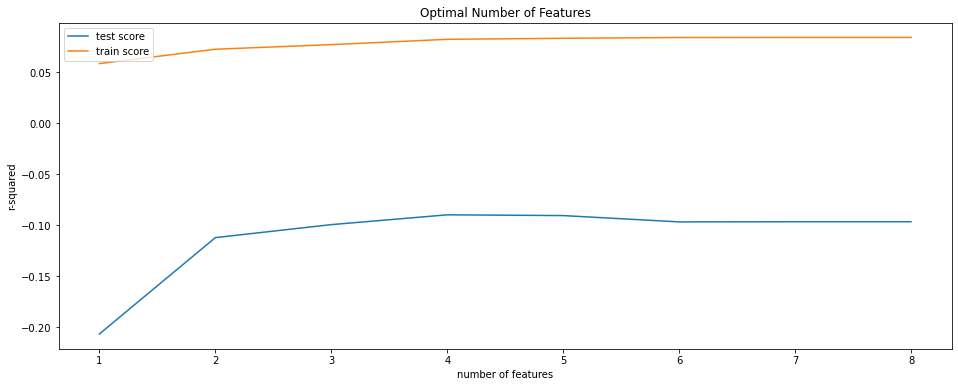

In [41]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [42]:
# final model
n_features_optimal = 6

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

-0.2359900271877371


# Conclusions

**Review of Results of Linear Regression**

Please note that RSquared values evaluated with SKLEarn can be negative.

Please see the following resources for additional insight:

> [Why R-Squared can be Negative - Medium](https://medium.com/analytics-vidhya/is-it-possible-to-have-a-negative-r-square-847a6a4a2fbe)



> [SKLearn R-Squared Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

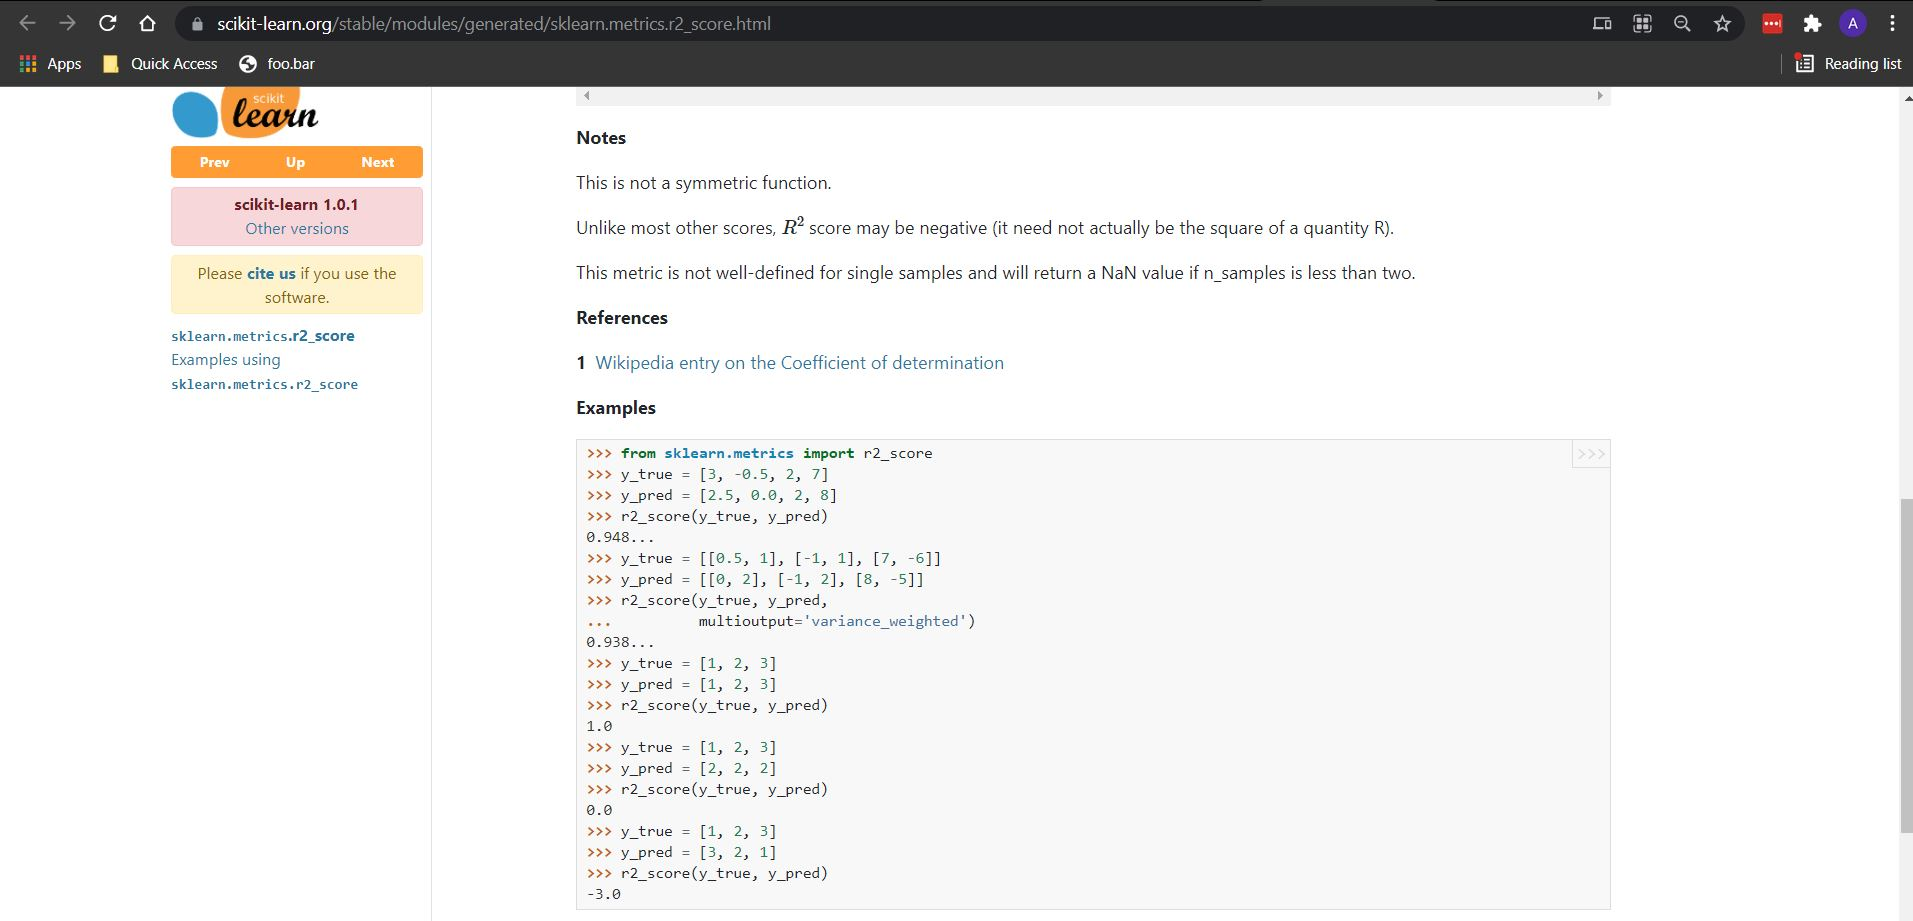






**Considering the model as a whole**

Evaluating a Support Vector Machines Classification model yielded accuraccy results of 0.9565217391304348.

Evaluating KNN on the dataset with polynomial features transform of degree=3 yielded the best regression fit with mean accuracy of 0.599 and standard deviation of 0.047.

Evaluating Linear Regression on the dataset with polynomial features transform of degree=3

These models would ideally be employed in tandem.  Given any tone analysis sample, the source video can be classified into a range of expected views with 97 perent accuracy.  Directly thereafter, the exact number of expected views can be predicted for the source video with an expected precision of 60 percent within a standard deviation of 5 percent.


**Remaining Steps**

In order to improve the fit, it will be necessary to obtain the model from the Kim & Sintas data set to serve as second order polynomial.